<a href="https://colab.research.google.com/github/Itsuki-Hamano123/practice-casualeffect/blob/master/econml/cm_causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ライブラリのインストール
- econml（マイクロソフト）

In [0]:
!pip install econml

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [0]:
cd /gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/econML

/gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/econML


In [0]:
ls

cm_causality.ipynb  econML_readDocumet.ipynb  model/


# アプリのCMを見たことで、アプリの利用時間がどのくらい増加したか分析（CATEの算出）

## 1. データの前処理






### 1-1. 分析対象のデータ読み込み

In [0]:
import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
DATA_DIR = "../datasets"
CSV_FIEL = "game_cm_abtest.csv"
data_path = DATA_DIR + "/" + CSV_FIEL

In [0]:
read_data = pd.read_csv(data_path)
read_data.head(3)

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,800.0,12.5,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,0,0,0,0,0,1,0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,0,37.825805,0,0


#### 統計量の確認

In [0]:
# 欠損数及び統計量の確認
read_data.describe()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.414400,0.074000,0.091200,0.588700,0.111500,0.208600,40.841900,0.640300,0.647000,0.566200,0.054200,0.075900,0.012300,0.117700,0.099900,0.039900,0.033900,357.829700,3.55234,0.148000,0.144800,0.620400,0.069900,0.016900,0.42300,0.013200,0.127800,0.173300,0.052200,0.140300,0.328800,0.164400,8096.497203,2846.783400,9.433300
std,0.492643,0.261784,0.287908,0.492094,0.314766,0.406328,10.465434,0.479936,0.477927,0.495623,0.226423,0.264851,0.110227,0.322269,0.299882,0.195734,0.180981,267.408383,3.37777,0.355118,0.351917,0.485312,0.254991,0.128903,0.49406,0.114136,0.333884,0.378525,0.222441,0.347315,0.469801,0.370657,7709.497437,17973.608991,54.475214
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.875270,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,103.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2502.245967,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,44.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,349.500000,2.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5944.444520,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,44.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,549.500000,4.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,11154.786148,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,800.000000,20.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,49036.055042,364814.000000,765.000000


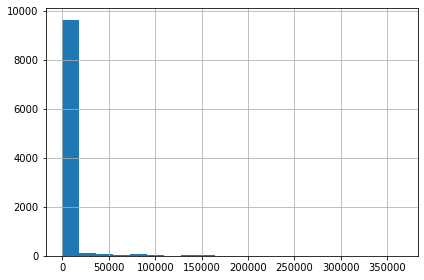

In [0]:
# アウトカムの分布を確認
read_data["gamesecond"].hist(bins=20)
plt.tight_layout()
plt.show()

### 不要なカラムの削除

In [0]:
UNNECESSARY_COLUMNS = ["gamedummy", "gamecount"]
analysis_data = read_data.drop(columns=UNNECESSARY_COLUMNS)
analysis_data.head(1)

,cm_dummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond
0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.4276,0


### TODO : アウトカムの対数変換

### 主要な列名を定数で管理

In [0]:
# 介入変数
TREATMENT_COLUMN = "cm_dummy"
# アウトカム
OUTCOME_COLUMN = "gamesecond"
# 交絡因子
COVARIATE_COLUMNS = [c for c in analysis_data.columns if c != TREATMENT_COLUMN and c != OUTCOME_COLUMN]

### 訓練データとテストデータに分割

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train_data, test_data = train_test_split(analysis_data, test_size=0.2, shuffle=True, random_state=7)
print("分割前のデータサイズ:{size}".format(size=analysis_data.shape))
print("訓練データサイズ:{size}".format(size=train_data.shape))
print("訓練データサイズ:{size}".format(size=test_data.shape))

分割前のデータサイズ:(10000, 33)
訓練データサイズ:(8000, 33)
訓練データサイズ:(2000, 33)


#### アウトカムの統計量の差を確認

In [0]:
print("---訓練データ内のアウトカムの統計量---\n{num}\n".format(num=train_data[OUTCOME_COLUMN].describe()))
print("---テストデータ内のアウトカムの統計量---\n{num}\n".format(num=test_data[OUTCOME_COLUMN].describe()))

---訓練データ内のアウトカムの統計量---
count      8000.000000
mean       2962.627250
std       18693.136545
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      364814.000000
Name: gamesecond, dtype: float64

---テストデータ内のアウトカムの統計量---
count      2000.000000
mean       2383.408000
std       14743.580547
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      223095.000000
Name: gamesecond, dtype: float64



## 2. 因果効果を推論するモデルの構築

In [0]:
import datetime
import pytz

import cloudpickle
from econml.drlearner import SparseLinearDRLearner
from econml.metalearners import DomainAdaptationLearner, XLearner
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def export_pkl_model_obj(dir_path, model_name, model, hyperparameter, protocol=4):
    """
    モデルとハイパーパラメータをpklファイルに書き出し
    """
    output_obj = {
        "model" : model,
        "hyperparameter" : hyperparameter
    }
    now = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')
    export_file = dir_path + "/" + model_name + "_" + now + ".pkl"
    with open(export_file, mode='wb') as f:
        f.write(cloudpickle.dumps(output_obj,protocol=protocol))
    return export_file


def load_pkl(dir_path, pkl_file_path):
    """
    pklファイルからモデルとハイパーパラメータのオブジェクトを読み込み
    """
    load_file = dir_path + "/" + pkl_file_path
    with open(load_file, mode="rb") as f:
        load_obj = cloudpickle.loads(f.read())
    return load_obj

### 2-1. SparseDRLearner

In [0]:
hyperparameter = {
    "model_propensity" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "binary:logistic"
    },
    "model_regression" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "reg:gamma"
    }
}

In [0]:
SPARSE_DRLEANER_TRAIN_MODE = False

model_name = 'sparse_drlearner'
model_obj_dir = "./model"
load_pkl_path = "sparse_drlearner_20200517192427.pkl"

if SPARSE_DRLEANER_TRAIN_MODE:
    Sparse_DRLearner_model = SparseLinearDRLearner(model_propensity=xgb.XGBClassifier(**hyperparameter["model_propensity"]),
                                                  model_regression=xgb.XGBRegressor(**hyperparameter["model_regression"]),
                                                  random_state=7)
    
    inference = 'debiasedlasso'
    Sparse_DRLearner_model.fit(Y=train_data[OUTCOME_COLUMN].values,
                              T=train_data[TREATMENT_COLUMN].values,
                              X=train_data[COVARIATE_COLUMNS].values,
                              inference=inference)
    
    if inference != 'bootstrap':
        res = export_pkl_model_obj(model_obj_dir, model_name, Sparse_DRLearner_model, hyperparameter)
        print("{model_name}を{file_path}に出力".format(model_name=model_name, file_path=res))

else :
    load_obj = load_pkl(model_obj_dir, load_pkl_path)
    Sparse_DRLearner_model = load_obj["model"]
    print("{model_name}を{file_path}から読み込み".format(model_name=model_name, file_path=load_pkl_path))
    print("ハイパーパラメータ{hyperparameter}".format(hyperparameter=load_obj["hyperparameter"]))

sparse_drlearnerを./model/sparse_drlearner_20200517192427.pklに出力


#### 回帰係数のp値を確認

In [0]:
summary_Sparse_DRLearner = Sparse_DRLearner_model.summary(T=1, feat_name=COVARIATE_COLUMNS)
summary_Sparse_DRLearner

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
area_kanto,-2818.249,1272.763,-2.214,0.027,-4911.758,-724.74
area_keihan,942.788,743.436,1.268,0.205,-280.055,2165.63
area_tokai,-2378.968,1170.37,-2.033,0.042,-4304.056,-453.88
area_keihanshin,1424.718,896.996,1.588,0.112,-50.71,2900.145
age,-39.342,35.353,-1.113,0.266,-97.493,18.808
sex,588.236,761.861,0.772,0.44,-664.915,1841.386
marry_dummy,1739.513,765.68,2.272,0.023,480.083,2998.944
job_dummy1,-924.113,738.475,-1.251,0.211,-2138.795,290.57
job_dummy2,4080.763,1625.715,2.51,0.012,1406.7,6754.826
job_dummy3,4415.921,1381.551,3.196,0.001,2143.472,6688.37


##### 統計的に有意な特徴量を取り出し

In [0]:
# 統計的に有意な特徴量（p値<0.05）
SIGNIFICANT_FEAT = ["area_kanto", "area_tokai","marry_dummy", "job_dummy2", "job_dummy3", "job_dummy4",
                    "job_dummy7", "inc", "fam_str_dummy2", "fam_str_dummy3", "fam_str_dummy5",
                    "M1", "M2", "TVwatch_day"]

#### MSE算出

In [0]:
# 訓練精度
MSE_DLLeaner_train = Sparse_DRLearner_model.score(Y=train_data[OUTCOME_COLUMN].values,
                                          T=train_data[TREATMENT_COLUMN].values,
                                          X=train_data[COVARIATE_COLUMNS].values)

# 検証精度
MSE_DLLeaner_test = Sparse_DRLearner_model.score(Y=test_data[OUTCOME_COLUMN].values,
                                          T=test_data[TREATMENT_COLUMN].values,
                                          X=test_data[COVARIATE_COLUMNS].values)

print("SparseDRLeanerの訓練データに対するMSE:{mse_train}".format(mse_train=MSE_DLLeaner_train))
print("SparseDRLeanerの検証データに対するMSE:{mse_test}".format(mse_test=MSE_DLLeaner_test))

SparseDRLeanerの訓練データに対するMSE:760694097.933948
SparseDRLeanerの検証データに対するMSE:484234958.90027654


#### 傾向スコアモデルの精度算出

In [0]:
def calc_model_score(model, train_X_values, train_y_values, val_X_values, val_y_values):
    """
    modelに用意されたscore関数を使い、訓練精度と検証精度を算出
    """
    train_score = model.score(X=train_X_values, y=train_y_values)
    val_score = model.score(X=val_X_values, y=val_y_values)
    return train_score, val_score

In [0]:
train_score, val_score = calc_model_score(Sparse_DRLearner_model.models_propensity[0], 
                                          train_data[COVARIATE_COLUMNS].values, train_data[TREATMENT_COLUMN].values,
                                          test_data[COVARIATE_COLUMNS].values, test_data[TREATMENT_COLUMN].values)
print("X-Leaner内の傾向スコアモデルの訓練精度:{train_score}".format(train_score=train_score))
print("X-Leaner内の傾向スコアモデルの検証精度:{val_score}".format(val_score=val_score))

X-Leaner内の傾向スコアモデルの訓練精度:0.921625
X-Leaner内の傾向スコアモデルの検証精度:0.892


### X-Learner

In [0]:
hyperparameter = {
    "models" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "reg:gamma"
    },
    "propensity_model" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "binary:logistic"
    },
    "cate_models" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "reg:squarederror"
    }
}

In [0]:
XLEARNER_TRAIN_MODE = False

model_name = 'xlearner'
model_obj_dir = "./model"
load_pkl_path = "xlearner_20200517192607.pkl"

if XLEARNER_TRAIN_MODE:
    XLearner_model = XLearner(models=xgb.XGBRegressor(**hyperparameter["models"]), # （反事実も含めた）アウトカム予測用のモデル定義
                             propensity_model=xgb.XGBClassifier(**hyperparameter["propensity_model"]), # 傾向スコア予測用のモデル定義
                             cate_models=xgb.XGBRegressor(**hyperparameter["cate_models"]), # CATE予測用のモデル定義
                             )

    #inference='bootstrap'
    inference=None
    XLearner_model.fit(Y=train_data[OUTCOME_COLUMN].values, # アウトカム
                      T=train_data[TREATMENT_COLUMN].values, # 介入変数
                      X=train_data[COVARIATE_COLUMNS].values, # 交絡因子
                      inference=inference 
                      )
    
    # inferenceをbootstrapに設定した場合、pklファイルに書き出さない
    # (最大深度の問題でpklファイルから読み込めないため)
    if inference != 'bootstrap':
        res = export_pkl_model_obj(model_obj_dir, model_name, XLearner_model, hyperparameter)
        print("{model_name}を{file_path}に出力".format(model_name=model_name, file_path=res))
        
else:
    load_obj = load_pkl(model_obj_dir, load_pkl_path)
    XLearner_model = load_obj["model"]
    print("{model_name}を{file_path}から読み込み".format(model_name=model_name, file_path=load_pkl_path))
    print("ハイパーパラメータ{hyperparameter}".format(hyperparameter=load_obj["hyperparameter"]))

xlearnerを./model/xlearner_20200517192607.pklに出力


#### 傾向スコアモデルの精度算出

In [0]:
train_score, val_score = calc_model_score(XLearner_model.propensity_models[0], 
                                          train_data[COVARIATE_COLUMNS].values, train_data[TREATMENT_COLUMN].values,
                                          test_data[COVARIATE_COLUMNS].values, test_data[TREATMENT_COLUMN].values)
print("X-Leaner内の傾向スコアモデルの訓練精度:{train_score}".format(train_score=train_score))
print("X-Leaner内の傾向スコアモデルの検証精度:{val_score}".format(val_score=val_score))

X-Leaner内の傾向スコアモデルの訓練精度:0.949625
X-Leaner内の傾向スコアモデルの検証精度:0.9165


### DA-Learner (Domain Adaptation Learner)

In [0]:
hyperparameter = {
    "models" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "reg:gamma"
    },
    "propensity_model" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "binary:logistic"
    },
    "final_models" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "reg:squarederror"
    }
}

In [0]:
DALEARNER_TRAIN_MODE = False

model_name = 'dalearner'
model_obj_dir = "./model"
load_pkl_path = "dalearner_20200517192702.pkl"

if DALEARNER_TRAIN_MODE:
    DALearner_model = DomainAdaptationLearner(models=xgb.XGBRegressor(**hyperparameter["models"]), # （反事実も含めた）アウトカム予測用のモデル定義
                                          propensity_model=xgb.XGBClassifier(**hyperparameter["propensity_model"]), # 傾向スコア予測用のモデル定義
                                          final_models=xgb.XGBRegressor(**hyperparameter["final_models"]), # CATE予測用のモデル定義
                                          )

    #inference='bootstrap'
    inference=None
    DALearner_model.fit(Y=train_data[OUTCOME_COLUMN].values,
                    T=train_data[TREATMENT_COLUMN].values,
                    X=train_data[COVARIATE_COLUMNS].values,
                    inference=inference
                    )
    
    # inferenceをbootstrapに設定した場合、pklファイルに書き出さない
    # (最大深度の問題でpklファイルから読み込めないため)
    if inference != 'bootstrap':
        res = export_pkl_model_obj(model_obj_dir, model_name, DALearner_model, hyperparameter)
        print("{model_name}を{file_path}に出力".format(model_name=model_name, file_path=res))
        
else:
    load_obj = load_pkl(model_obj_dir, load_pkl_path)
    DALearner_model = load_obj["model"]
    print("{model_name}を{file_path}から読み込み".format(model_name=model_name, file_path=load_pkl_path))
    print("ハイパーパラメータ{hyperparameter}".format(hyperparameter=load_obj["hyperparameter"]))

dalearnerを./model/dalearner_20200517192702.pklに出力


#### 傾向スコアモデルの精度算出
傾向スコアモデルの作り方はXLeanerと変わらないので、精度も同じ

In [0]:
train_score, val_score = calc_model_score(DALearner_model.propensity_models[0], 
                                          train_data[COVARIATE_COLUMNS].values, train_data[TREATMENT_COLUMN].values,
                                          test_data[COVARIATE_COLUMNS].values, test_data[TREATMENT_COLUMN].values)
print("DA-Leaner内の傾向スコアモデルの訓練精度:{train_score}".format(train_score=train_score))
print("DA-Leaner内の傾向スコアモデルの検証精度:{val_score}".format(val_score=val_score))

DA-Leaner内の傾向スコアモデルの訓練精度:0.949625
DA-Leaner内の傾向スコアモデルの検証精度:0.9165


### (統計的に有意な特徴量のみで)X-Learner

In [0]:
hyperparameter = {
    "models" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "reg:gamma"
    },
    "propensity_model" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "binary:logistic"
    },
    "cate_models" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "reg:squarederror"
    }
}

In [0]:
SIGNIFICANT_FEAT_XLEARNER_TRAIN_MODE = False

model_name = 'significant_feat_xlearner'
model_obj_dir = "./model"
load_pkl_path = "significant_feat_xlearner_20200517192843.pkl"

if SIGNIFICANT_FEAT_XLEARNER_TRAIN_MODE:
    Significant_feat_XLeaner_model = XLearner(models=xgb.XGBRegressor(**hyperparameter["models"]), # （反事実も含めた）アウトカム予測用のモデル定義
                             propensity_model=xgb.XGBClassifier(**hyperparameter["propensity_model"]), # 傾向スコア予測用のモデル定義
                             cate_models=xgb.XGBRegressor(**hyperparameter["cate_models"]), # CATE予測用のモデル定義
                             )

    #inference='bootstrap'
    inference=None
    Significant_feat_XLeaner_model.fit(Y=train_data[OUTCOME_COLUMN].values, # アウトカム
                                       T=train_data[TREATMENT_COLUMN].values, # 介入変数
                                       X=train_data[SIGNIFICANT_FEAT].values, # 交絡因子
                                       inference=inference
                                       )
    
    # inferenceをbootstrapに設定した場合、pklファイルに書き出さない
    # (最大深度の問題でpklファイルから読み込めないため)
    if inference != 'bootstrap':
        res = export_pkl_model_obj(model_obj_dir, model_name, Significant_feat_XLeaner_model, hyperparameter)
        print("{model_name}を{file_path}に出力".format(model_name=model_name, file_path=res))
        
else:
    load_obj = load_pkl(model_obj_dir, load_pkl_path)
    Significant_feat_XLeaner_model = load_obj["model"]
    print("{model_name}を{file_path}から読み込み".format(model_name=model_name, file_path=load_pkl_path))
    print("ハイパーパラメータ{hyperparameter}".format(hyperparameter=load_obj["hyperparameter"]))

significant_feat_xlearnerを./model/significant_feat_xlearner_20200517192843.pklに出力


#### 傾向スコアモデルの精度算出

In [0]:
train_score, val_score = calc_model_score(Significant_feat_XLeaner_model.propensity_models[0], 
                                          train_data[SIGNIFICANT_FEAT].values, train_data[TREATMENT_COLUMN].values,
                                          test_data[SIGNIFICANT_FEAT].values, test_data[TREATMENT_COLUMN].values)
print("有意な特徴量のみを用いたX-Leaner内の傾向スコアモデルの訓練精度:{train_score}".format(train_score=train_score))
print("有意な特徴量のみを用いたX-Leaner内の傾向スコアモデルの検証精度:{val_score}".format(val_score=val_score))

有意な特徴量のみを用いたX-Leaner内の傾向スコアモデルの訓練精度:0.908625
有意な特徴量のみを用いたX-Leaner内の傾向スコアモデルの検証精度:0.873


### (統計的に有意な特徴量のみで)DA-Learner

In [0]:
hyperparameter = {
    "models" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "reg:gamma"
    },
    "propensity_model" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "binary:logistic"
    },
    "final_models" : {
        "n_estimators" : 600,
        "random_state" : 7,
        "objective" : "reg:squarederror"
    }
}

In [0]:
SIGNIFICANT_FEAT_DALEARNER_TRAIN_MODE = False

model_name = 'significant_feat_dalearner'
model_obj_dir = "./model"
load_pkl_path = "significant_feat_dalearner_20200517192943.pkl"

if SIGNIFICANT_FEAT_DALEARNER_TRAIN_MODE:
    Significant_feat_DALearner_model = DomainAdaptationLearner(models=xgb.XGBRegressor(**hyperparameter["models"]), # （反事実も含めた）アウトカム予測用のモデル定義
                                          propensity_model=xgb.XGBClassifier(**hyperparameter["propensity_model"]), # 傾向スコア予測用のモデル定義
                                          final_models=xgb.XGBRegressor(**hyperparameter["final_models"]), # CATE予測用のモデル定義
                                          )

    #inference='bootstrap'
    inference=None
    Significant_feat_DALearner_model.fit(Y=train_data[OUTCOME_COLUMN].values,
                    T=train_data[TREATMENT_COLUMN].values,
                    X=train_data[SIGNIFICANT_FEAT].values,
                    inference=inference
                    )
    
    # inferenceをbootstrapに設定した場合、pklファイルに書き出さない
    # (最大深度の問題でpklファイルから読み込めないため)
    if inference != 'bootstrap':
        res = export_pkl_model_obj(model_obj_dir, model_name, Significant_feat_DALearner_model, hyperparameter)
        print("{model_name}を{file_path}に出力".format(model_name=model_name, file_path=res))
        
else:
    load_obj = load_pkl(model_obj_dir, load_pkl_path)
    Significant_feat_DALearner_model = load_obj["model"]
    print("{model_name}を{file_path}から読み込み".format(model_name=model_name, file_path=load_pkl_path))
    print("ハイパーパラメータ{hyperparameter}".format(hyperparameter=load_obj["hyperparameter"]))

significant_feat_dalearnerを./model/significant_feat_dalearner_20200517192943.pklに出力


## CATEの結果を描画
econmlに収録されているInterpreterを使う

In [0]:
from econml.cate_interpreter import SingleTreeCateInterpreter

In [0]:
def plot_model_interpreter(model, X_df, model_inference=False):
    """
    Interpreterを使ってCATEの結果を描画
    """
    # 信頼区間も算出可能なモデルの場合True
    include_model_uncertainty = model_inference

    intrp = SingleTreeCateInterpreter(include_model_uncertainty=include_model_uncertainty, 
                                      max_depth=3, min_samples_leaf=10,
                                      random_state=7)
    
    # We interpret the CATE model's behavior based on the features used for heterogeneity
    intrp.interpret(model, X_df.values)

    # Plot the tree
    plt.figure(figsize=(35, 10))
    intrp.plot(feature_names=X_df.columns, fontsize=12)
    plt.show()

### SparseDRLearner

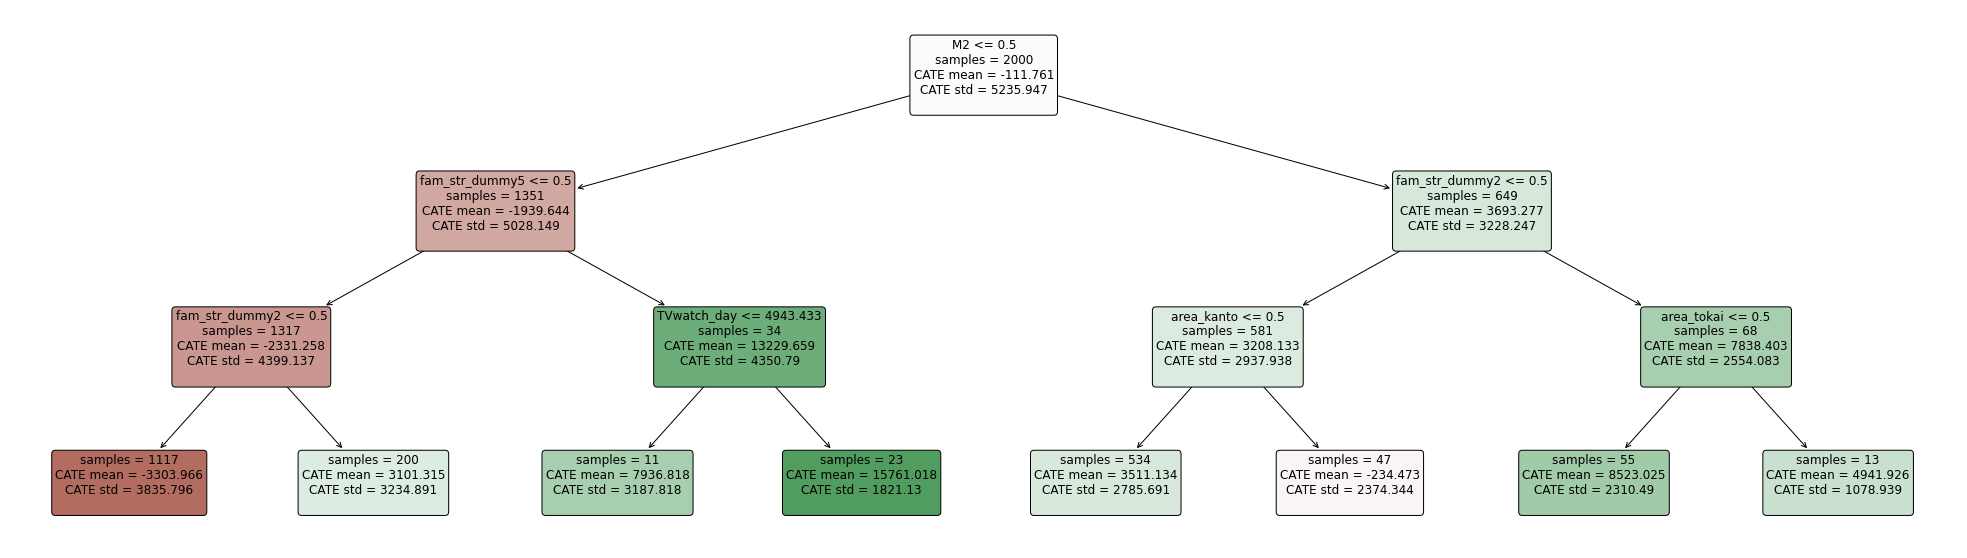

In [0]:
plot_model_interpreter(Sparse_DRLearner_model, test_data[COVARIATE_COLUMNS])

### X-Leaner

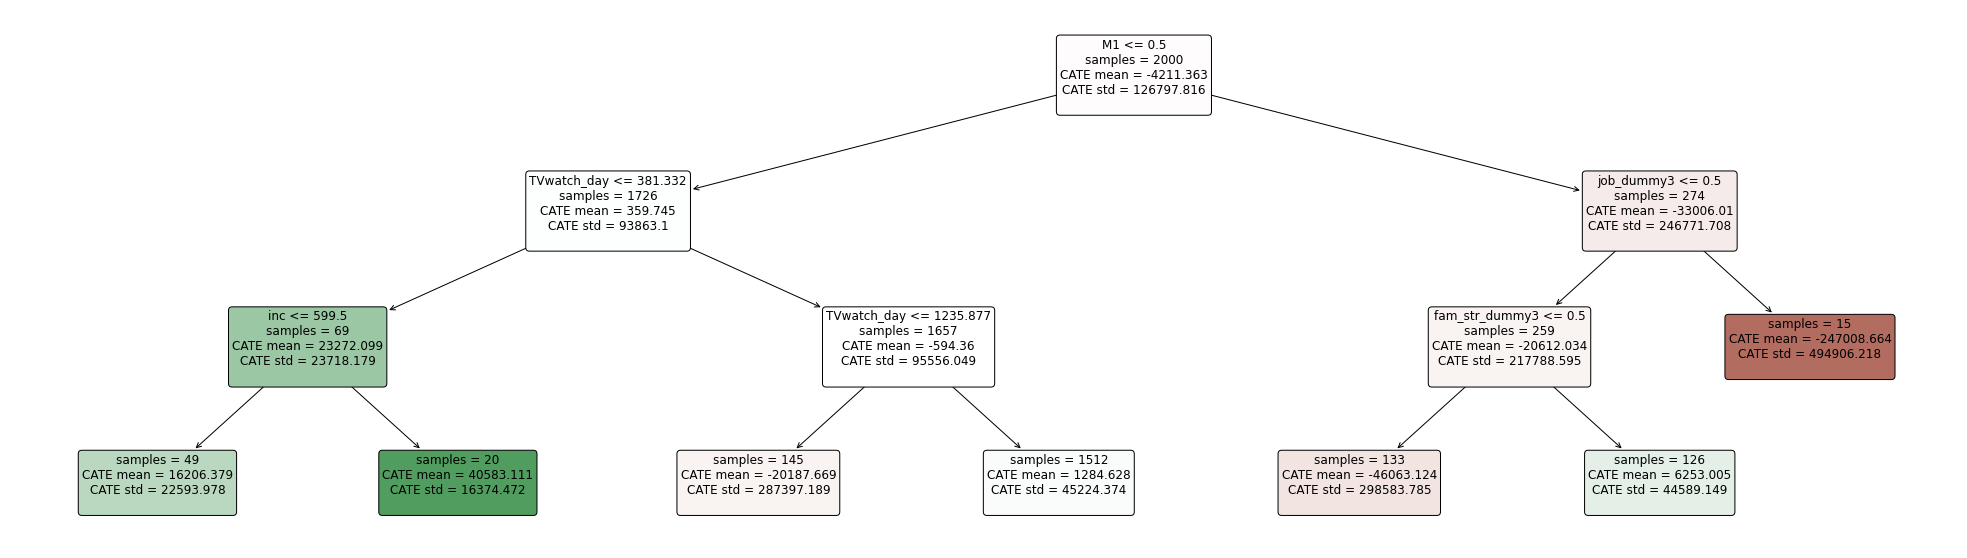

In [0]:
plot_model_interpreter(Significant_feat_XLeaner_model, test_data[SIGNIFICANT_FEAT])

#### DA-Leaner

/usr/local/lib/python3.6/dist-packages/sklearn/tree/export.py:210: RuntimeWarning: invalid value encountered in double_scalars
  / (1 - sorted_values[1]))


ValueError: ignored

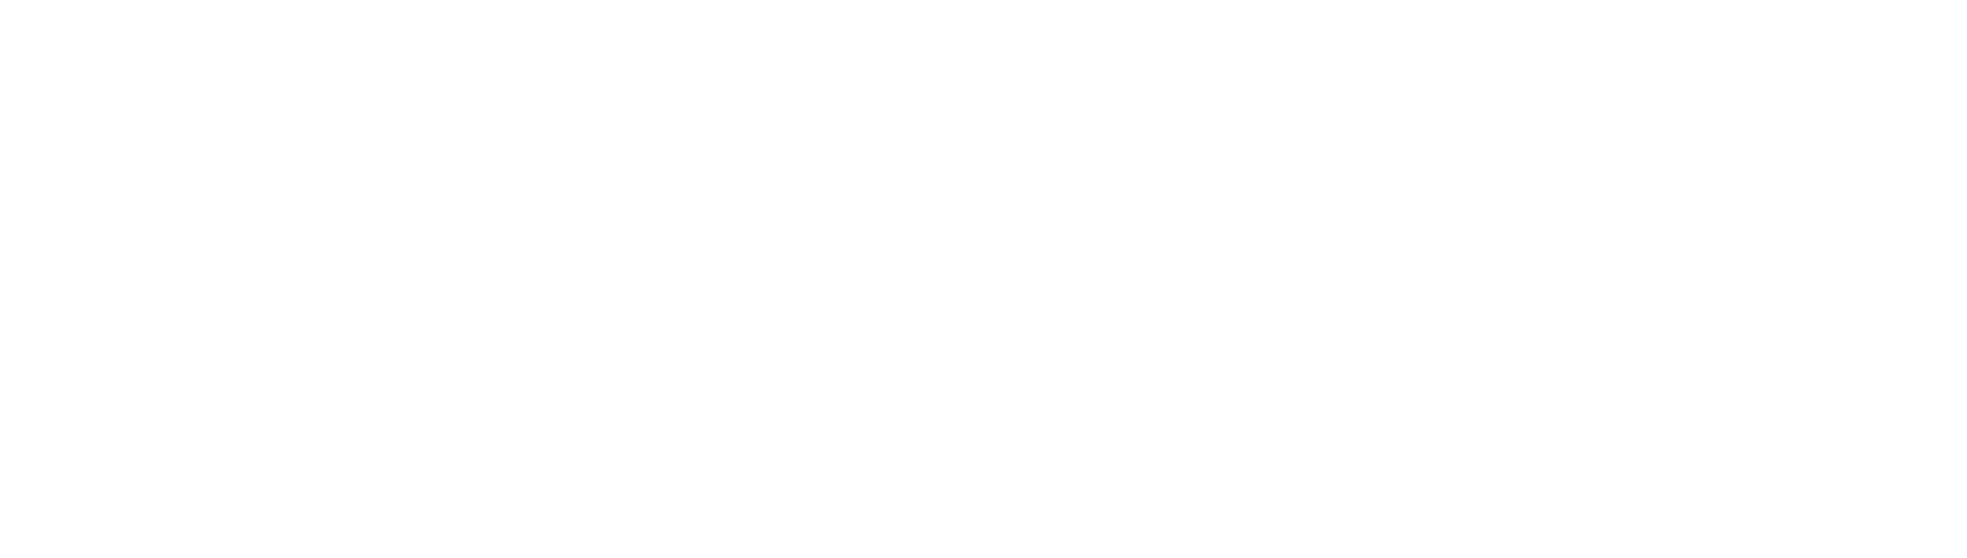

In [0]:
plot_model_interpreter(Significant_feat_DALearner_model, analysis_data[SIGNIFICANT_FEAT])

## 広告配信の戦略を決める
econmlに収録されているPolicyInterpreterを使う

In [0]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

In [0]:
def plot_model_policyinterpreter(model, X_df):
    # We find a tree-based treatment policy based on the CATE model
    intrp = SingleTreePolicyInterpreter(risk_level=0.05, 
                                        max_depth=3, min_samples_leaf=1,
                                        min_impurity_decrease=.001,
                                        random_state=7)
    intrp.interpret(model, X_df.values, sample_treatment_costs=0.2)
    # Plot the tree
    plt.figure(figsize=(35, 10))
    intrp.plot(feature_names=X_df.columns, fontsize=12)
    plt.show()

### SparseDRLearner

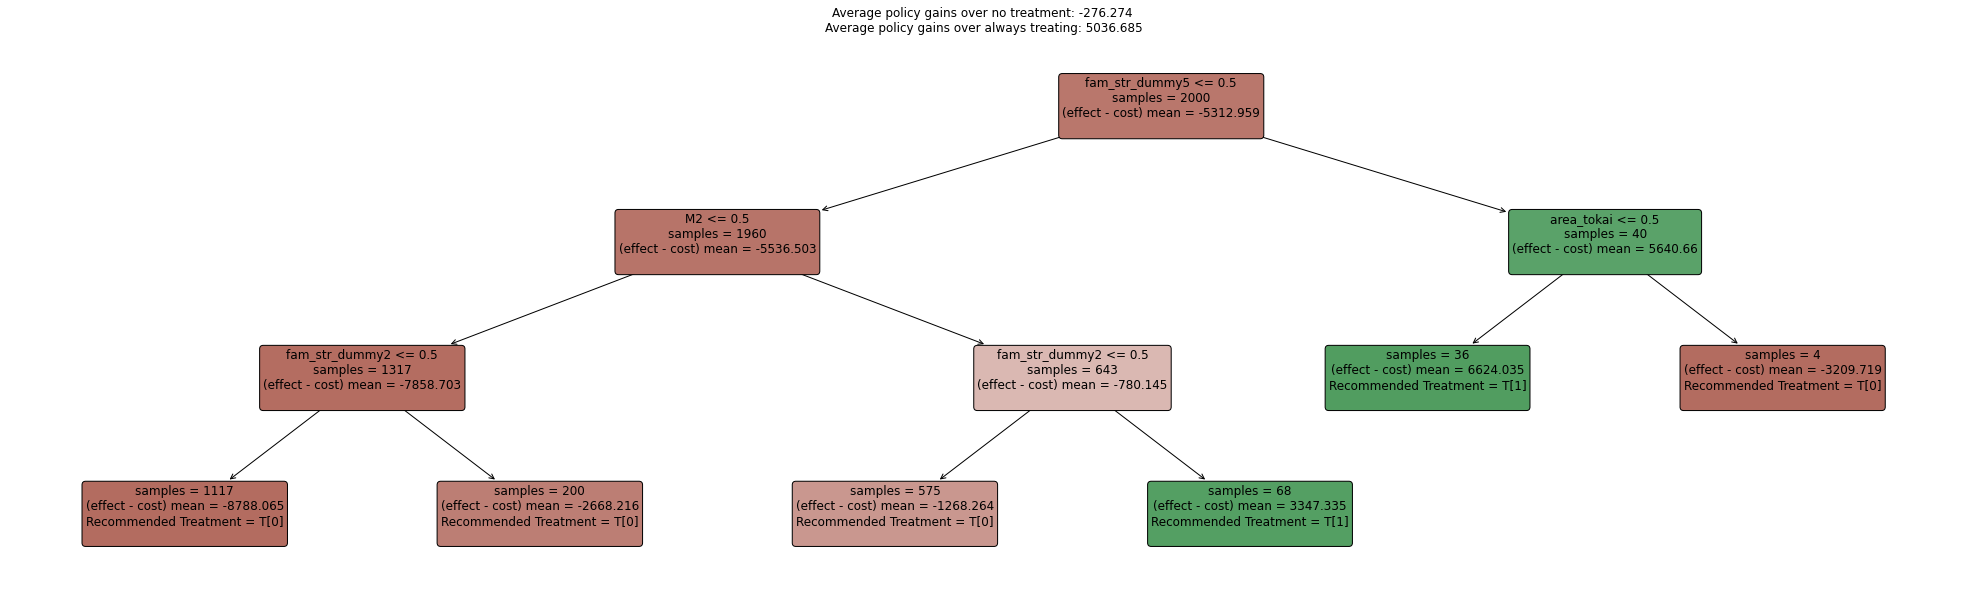

In [0]:
plot_model_policyinterpreter(Sparse_DRLearner_model, test_data[COVARIATE_COLUMNS])